In [10]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:60% !important; }</style>"))

/tmp/ipykernel_29356/1693907628.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


In [11]:
import torch
from torchvision import datasets, transforms
import torch.nn as nn


batch_size = 128
train_dataset = datasets.MNIST('./data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
test_dataset =  datasets.MNIST('./data', train=False, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [50000, 10000])
print(len(train_dataset), len(val_dataset), len(test_dataset))

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

50000 10000 10000


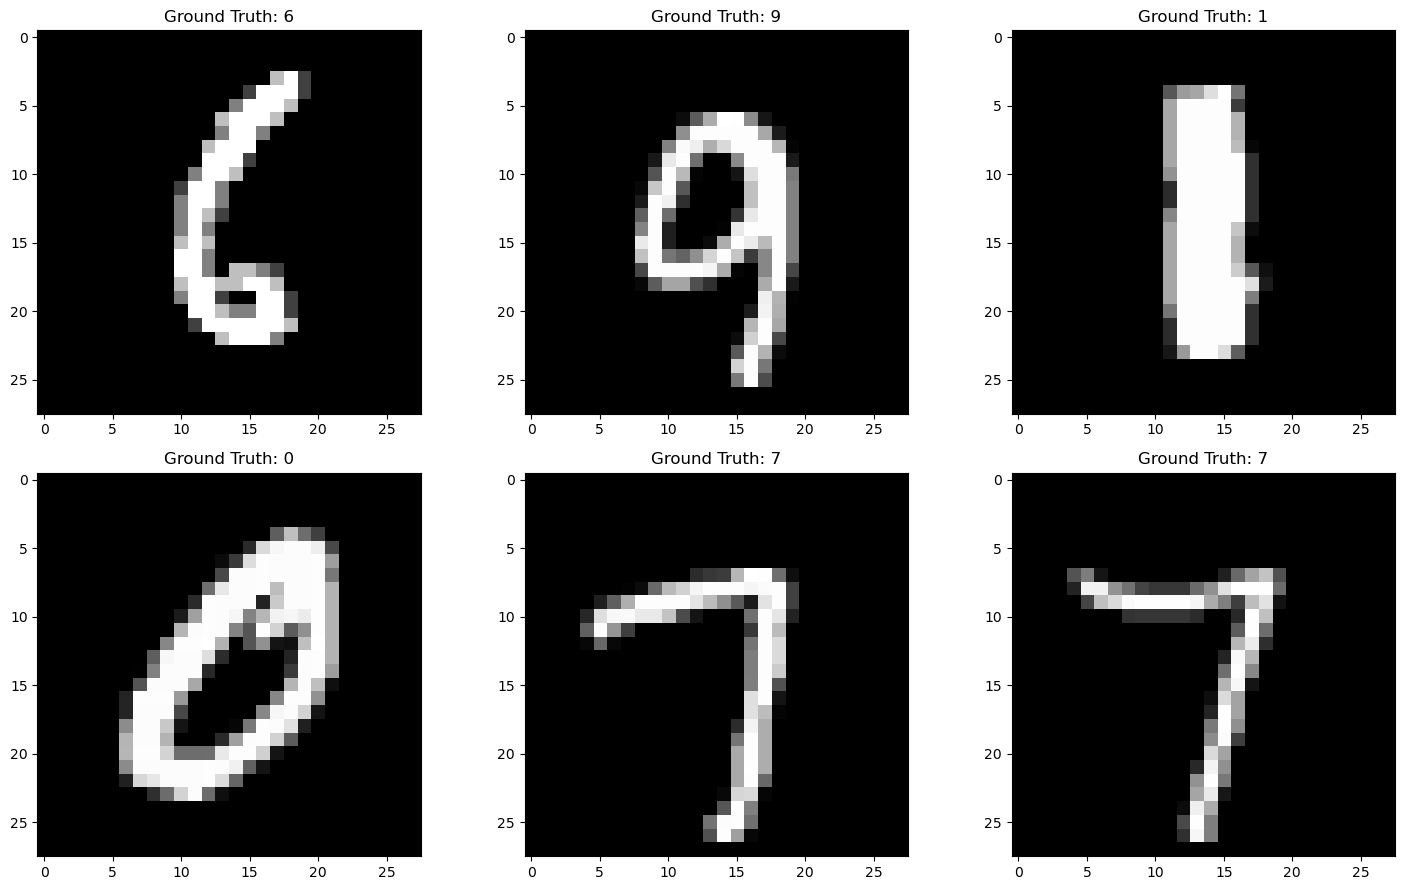

In [12]:
examples = enumerate(train_loader)
batch_idx, (example_data, example_targets) = next(examples)  

import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 9))
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.title("Ground Truth: {}".format(example_targets[i]))
plt.show()

In [13]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x


In [14]:
cls_loss = nn.CrossEntropyLoss()

In [17]:
print(torch.cuda.is_available())
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

True
cuda


In [21]:
import torch.optim as optim
from sklearn.metrics import accuracy_score
import time

#cpu -> 2.7
#gpu -> 2.8

# ====== Construct Model ====== #
model = LinearModel()
model.to(device)
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 30
for i in range(epoch):
    ts = time.time()
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X.to(device))

        loss = cls_loss(pred_y.squeeze(), true_y.to(device))
        loss.backward() 
        optimizer.step() 
        train_loss += loss.item()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X.to(device))

            loss = cls_loss(pred_y.squeeze(), true_y.to(device))
            val_loss += loss.item()
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)


    # ====== Evaluation ======= #
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Evaluation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 

    with torch.no_grad(): # [21.01.05 코드 클린업] Evaluation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in test_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X.to(device)).max(1, keepdim=True)[1].squeeze()
            correct += pred_y.eq(true_y.to(device)).sum()

        acc = correct.item() / len(test_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)
        
        te = time.time()
    
    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%, {:3.3f}'.format(i, train_loss, val_loss, acc*100, te-ts))

Number of 7850 parameters
Epoch: 0, Train Loss: 0.7507143244718957, Val Loss: 0.47870319232910497, Test Acc: 88.4%, 2.898
Epoch: 1, Train Loss: 0.43936674449297475, Val Loss: 0.40281900235369233, Test Acc: 89.53%, 2.876
Epoch: 2, Train Loss: 0.3909093576014194, Val Loss: 0.37101176796080193, Test Acc: 90.25%, 2.890
Epoch: 3, Train Loss: 0.36697930471061746, Val Loss: 0.353904873321328, Test Acc: 90.78%, 2.741
Epoch: 4, Train Loss: 0.35184411247215613, Val Loss: 0.3408836131986183, Test Acc: 90.82000000000001%, 2.869
Epoch: 5, Train Loss: 0.34117059577304076, Val Loss: 0.3315037231467947, Test Acc: 90.97%, 2.867
Epoch: 6, Train Loss: 0.3332648393900498, Val Loss: 0.3245230357669577, Test Acc: 91.08000000000001%, 2.856
Epoch: 7, Train Loss: 0.32641006144873624, Val Loss: 0.3192313958572436, Test Acc: 91.3%, 2.880
Epoch: 8, Train Loss: 0.32110307516191927, Val Loss: 0.31401350471792344, Test Acc: 91.28%, 2.867
Epoch: 9, Train Loss: 0.3166230924217902, Val Loss: 0.31056645814376543, Test A

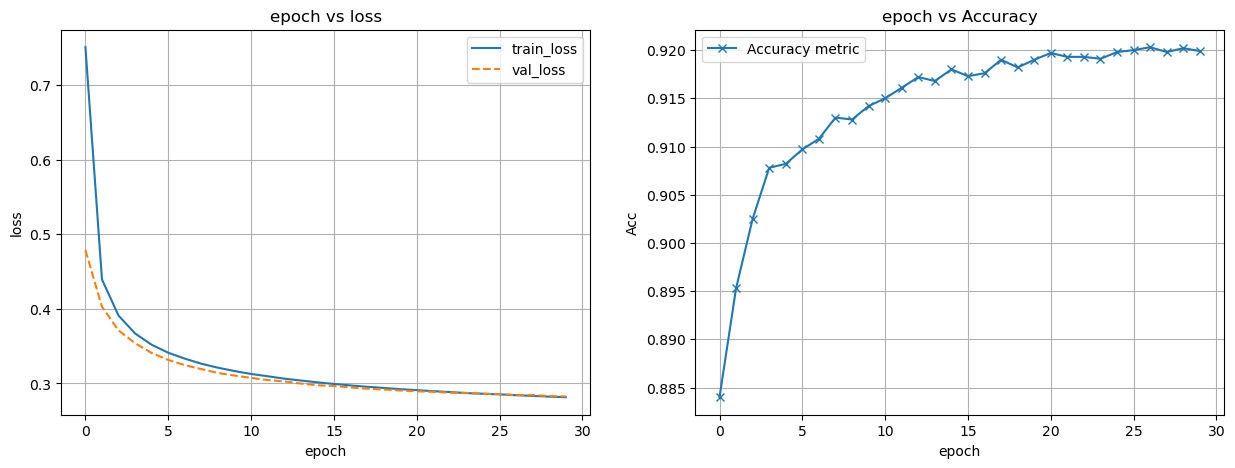

In [22]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()